# CEO-REQUEST CHALLENGE

***CEO Question***

How do we increase customer satisfaction (so as to increase profit margins) while maintaining a healthy order volume?

**Findings from our Preliminary Analysis of the Orders and Sellers Datasets**

- The more sellers (`number_of_sellers`) and products (`number_of_products`) that are combined into a single order, the lower the order `review_score`.  
- The `wait_time` for the order, which is made up of two components (seller's `delay_to_carrier` + `carrier_delivery_time`) also has a significant association with low review scores.  

While orders that contain more than a single seller or product do have a significant association with low review scores, orders that contain multiple sellers do not make up a large portion of orders on the platform, so any policy changes (e.g. restricting orders to a single seller) would not have a large impact on the bottom line. 

Instead, we'll see if we can make improvements based on the second finding of low review scores associated with `wait_time`. Since `carrier_delivery_time` is less directly in our control, we'll identify sellers who have been receiving low review scores and see the impact on Olist's profits if we remove them. 

In this notebook, we'll quantify the impact of keeping these poor-performing sellers on the platform, and make specific recommendations to the CEO on what changes can be made in the short term to increase customer satisfaction and Olist profit margins. 

**Next Steps to our Analysis**
1. Identify how much revenue each seller brings in
2. Calculate the cost to Olist of bad reviews for each seller
3. Calculate the profit to Olist per seller and see the distribution 
3. Understand the impact on Olist's profits by poor performers
4. Find out how much removing these sellers would impact Olist's IT costs 


**Problem statement** ---REMOVE

To analyse the impact of removing the worst sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin




Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 



# START

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from olist.seller import Seller
from olist.data import Olist 

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Let's look again at our Sellers data
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99


In [3]:
#CAN BE DELETED LATER
#export dataset for Tableau
path = '../data/csv/seller_dataset_modified.csv'
sellers.to_csv(path_or_buf=path, index=False)

## Revenue per seller

Olist generates revenue from its sellers through two components:
1. **Monthly Membership Fee** - sellers pay Olist an **80 BRL** (~$15 USD) monthly fee to use the platform
2. **Revenue Share** - for every order on the platform, Olist takes a **10% cut** based on the product price  of each item (excl. shipping)


In [4]:
# Revenue Calculation: Monthly Membership Fee Calculation + Revenue Share

# Calculate total time on platform (in months)
number_of_months_on_olist = (sellers.date_last_sale - sellers.date_first_sale) / np.timedelta64(1, 'M')
sellers['months_on_olist'] = number_of_months_on_olist.map(lambda x: 1 if x < 1 else np.ceil(x))

# Calculate total revenue seller generates for Olist
sellers['revenue_per_seller'] = sellers.months_on_olist * 80 + sellers.sales * 0.1
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales,revenue_per_seller
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,15.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,1.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,1.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,96.799


## Costs per seller

Because poor reviews from customers can have several direct and indirect costs to a business (e.g. customer support utilization, bad word-of-mouth, low repeat rate, etc.), we'll use the following table to estimate monetary costs associated with bad reviews:

**Estimated cost to Olist per bad review (in Brazilian Reals)** *(100 BRL $\approx$ 20 USD)*
- **1 star:** 100
- **2 stars:** 50
- **3 stars:** 40
- **4 stars:** 0
- **5 stars:** 0

In [5]:
sellers[['seller_id','seller_review_score','review_cost_per_seller']].head()

,seller_id,seller_review_score,review_cost_per_seller
0,3442f8959a84dea7ee197c632cb2df15,3.00,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,4.55,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,5.00,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,5.00,0
4,51a04a8a6bdcb23deccc82b0b80742cf,1.00,100


`seller_review_score` is the average review score earned by a seller

`review_cost_per_seller` is the total cost from all bad reviews for each seller, calculated first by assigning a monetary cost for any review receiving 3 stars or less, and then summing up the total cost of these bad reviews

# Profits per seller 

Now that we know how much revenue each seller generates for Olist and also the cost of bad reviews, let's calculate the profit to Olist from each seller. This will allow us to see more clearly which sellers are a drag on Olist's bottom line and by how much. 

We've also been asked by the CEO to consider the IT costs associated with running the platform, but for now we'll set that aside in our analysis and examine it later.   

In [101]:
# Calculate the profit as 'revenue_per_seller' - 'review_cost_per_seller'
sellers['profit_per_seller'] = sellers.revenue_per_seller - sellers.review_cost_per_seller
sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].groupby(by='seller_id').sum()

sellers[['seller_id', 'revenue_per_seller', 'review_cost_per_seller', 'profit_per_seller']].head()

,seller_id,revenue_per_seller,review_cost_per_seller,profit_per_seller
0,53243585a1d6dc2643021fd1853d8905,23237.605,5270,17967.605
1,7e93a43ef30c4f03f38b393420bc753a,19403.187,4800,14603.187
2,fa1c13f2614d7b5c4749cbc52fecda94,21004.203,6750,14254.203
3,edb1ef5e36e0c8cd84eb3c9b003e486d,8808.455,1520,7288.455
4,ccc4bbb5f32a6ab2b7066a4130f114e3,9000.462,2220,6780.462


Let's take a quick look at the distribution of `profit_per_seller`.

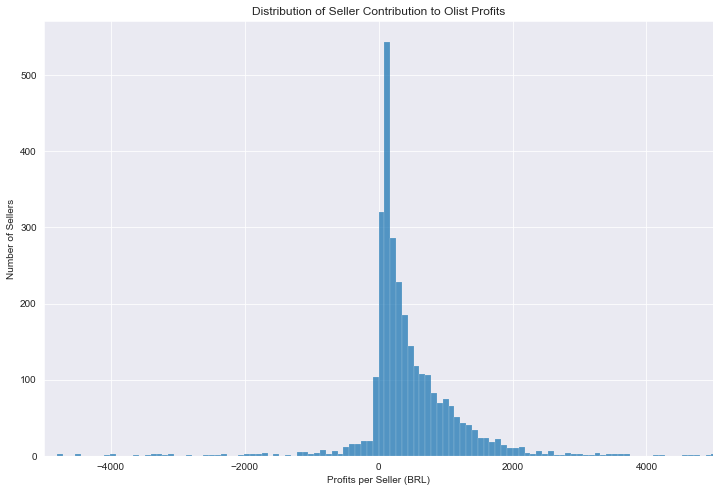

In [8]:
# Plot histogram of sellers' financial impact
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')

ax = sns.histplot(sellers.profit_per_seller)
ax.set_xlim(xmin=-5000, xmax=5000)
ax.set_xlabel('Profits per Seller (BRL)')
ax.set_ylabel('Number of Sellers')
ax.set_title('Distribution of Seller Contribution to Olist Profits');

In [9]:
# Summary stats
sellers.profit_per_seller.describe()

count     2970.000000
mean       424.055631
std       1274.295160
min     -22419.517000
25%         93.000000
50%        285.790500
75%        720.593750
max      17967.605000
Name: profit_per_seller, dtype: float64

**Interpretation of Results**

From our histogram and summary stats of sellers' contribution to Olist profits, it appears as though the middle 50% of sellers on the platform generate anywhere from **93 to 721 BRL** (~17 to 134 USD) for Olist. We can also see a number of sellers with a negative impact on profits. 
 
Next, let's see if we can find out more about these sellers who are pulling down Olist profits. 

# Understanding the Impact of Poor-performing Sellers

To get a clearer picture of how much impact these poor-performing sellers have on Olist's profits, we'll break this question down into smaller pieces:

1. How many sellers have a negative impact on profits?
2. How much in total do these sellers affect Olist profits? 

### How many sellers are negatively impacting Olist profits?

Let's find the total number of poor-performing sellers, and also see what proportion they make up on the platform.

In [133]:
# Simple function to create column indicating whether sellers have positive or negative impact on profits
def olist_impact(x):
    if x < 0:
        return 'negative'
    else:
        return 'positive'

sellers['impact'] = sellers['profit_per_seller'].apply(olist_impact)
sellers[['impact','seller_id']].groupby('impact').count()

,seller_id
impact,
negative,276
positive,2694


In [137]:
# Total number of sellers
sellers.seller_id.count()

2970

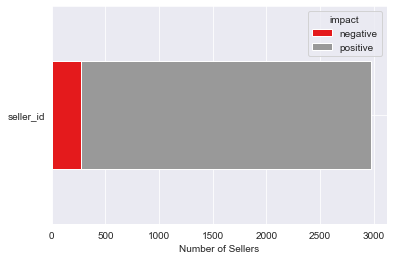

In [132]:
# Bar plot to visualize what proportion poor-performing sellers have
sellers[['impact','seller_id']].groupby('impact').count().transpose().plot.barh(stacked=True, cmap='Set1')
plt.xlabel('Number of Sellers');


In [141]:
# Proportion of poor-performing sellers
sellers[['impact']].value_counts(normalize=True)

impact  
positive    0.907071
negative    0.092929
dtype: float64

We can now see that there are **276 sellers** (or **roughly 9%** of all sellers) who negatively impact Olist profits. 

### How much do poor-performing sellers impact Olist profits?

To get a better picture of how much impact these sellers have on Olist's total profits, let's create a **whale curve** which will show us what percentage of sellers represent 'x' percentage of cumulative profits. 

To build our whale curve, we'll first sort our sellers from most to least profitable. Then we'll plot the cumulative profits from each additional seller to the platform.   

In [143]:
# Sort sellers by how much profit each contributes to Olist (from most to least)
sellers.sort_values('profit_per_seller', ignore_index=True, inplace=True, ascending=False)

# Calculate cumulative profits to Olist with each additional seller
sellers['cumulative_profits'] = sellers['profit_per_seller'].cumsum()
sellers.tail()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion,cumulative_orders,cumulative_it_cost,it_unit_cost,it_marg_cost,diff_unit_marg_it
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,...,-13066.431,negative,1335110.855,106.007854,99.86532,93332,451890.181743,4.841750,7.262625,-2.420875
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,...,-15952.248,negative,1319158.607,104.741245,99.89899,94478,460238.646312,4.871384,7.307076,-2.435692
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,...,-18051.158,negative,1301107.449,103.307982,99.93266,96184,472760.624944,4.915169,7.372754,-2.457585
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,...,-19242.708,negative,1281864.741,101.780111,99.96633,97990,486138.127028,4.961099,7.441649,-2.480550
2969,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,19.0,0.127957,0.510215,...,-22419.517,negative,1259445.224,100.000000,100.00000,99844,500000.000000,5.007812,7.511718,-2.503906


In [13]:
# Total cumulative profits for Olist
total_profits = sellers['cumulative_profits'].iloc[-1]
total_profits

1259445.2239999846

In [14]:
# Calculate the cumulative percentage of profits represented by each additional seller
sellers['percent_profits'] = sellers['cumulative_profits'].div(total_profits).mul(100)

# Calculate the proportion of sellers represented (in percent)
sellers['seller_proportion'] = (sellers.index+1) / sellers.seller_id.count() * 100

whale_df = sellers[['seller_id', 'percent_profits', 'seller_proportion']]
whale_df.tail()

,seller_id,percent_profits,seller_proportion
2965,8b321bb669392f5163d04c59e235e066,106.007854,99.86532
2966,ea8482cd71df3c1969d7b9473ff13abc,104.741245,99.89899
2967,cc419e0650a3c5ba77189a1882b7556a,103.307982,99.93266
2968,4a3ca9315b744ce9f8e9374361493884,101.780111,99.96633
2969,6560211a19b47992c3666cc44a7e94c0,100.000000,100.00000


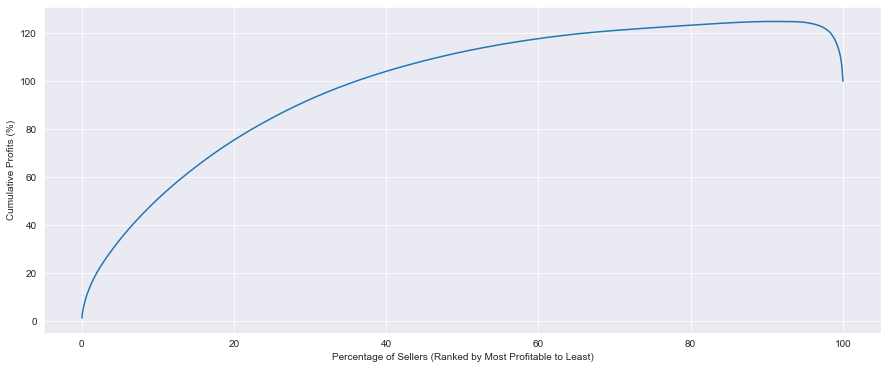

In [145]:
# Build our whale curve
plt.figure(figsize=(15,6))
sns.lineplot(data=sellers, x='seller_proportion', y='percent_profits')
plt.xlabel('Percentage of Sellers (Ranked by Most Profitable to Least)')
plt.ylabel('Cumulative Profits (%)');

Our whale curve helps to underscore that roughly 80% of our sellers contribute to 120% of Olist profits. Another 10% of sellers have a negligible impact. And, the **remaining 10% drag down profits by 20%**.  

Let's visualize this another way. What would Olist profits be if poor-performing sellers were no longer on the platform.

In [16]:
# Amount of reduction in profits due to bad reviews
neg_profits = sellers[sellers['impact']=='negative'].profit_per_seller.cumsum()
neg_profits.iloc[-1]

-313276.50200000097

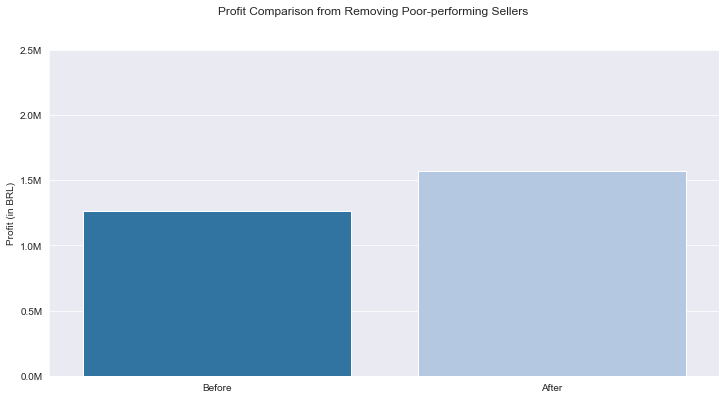

In [231]:
# Bar chart showing profit comparison after removal of poor-performing sellers

fig = plt.figure(figsize=(12,6))
x_values = ['Before', 'After']
y_values = [sellers.cumulative_profits.iloc[-1], sellers.cumulative_profits.iloc[-1] - neg_profits.iloc[-1]]
ax = sns.barplot(data=sellers, x=x_values, y=y_values, palette='tab20')

plt.ylabel('Profit (in BRL)')
plt.ylim(0, 2500000)
plt.suptitle('Profit Comparison from Removing Poor-performing Sellers', fontsize=12)
ax.set_yticks(ax.get_yticks())
yticklabels=['{:3.1f}'.format(y) + 'M' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(yticklabels);

If Olist were to drop sellers who had a negative impact on profits, the platform would see an immediate boost in profits of **313,277 BRL** ($58,246 USD)! 

## What's the impact if we factor in IT costs?

FROM PROBLEM STATEMENT --REMOVE

In addition, Olist’s IT costs (servers, etc…) increase with the amount of orders processed, albeit less and less rapidly (scale effects).
For the sake of simplicity, we will consider Olist’s total cumulative IT Costs to be proportional to the square-root of the total cumulative number of orders approved.
#The IT department also told you that since the birth of the marketplace, cumulative IT costs have amounted to 500,000 BRL.

In [18]:
sellers.tail()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,n_orders,quantity,quantity_per_order,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion
2965,8b321bb669392f5163d04c59e235e066,sao paulo,SP,0.0,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,10.0,0.118770,0.567338,...,943,1018,1.079533,17535.69,2553.569,-13066.431,negative,1335110.855,106.007854,99.86532
2966,ea8482cd71df3c1969d7b9473ff13abc,sao paulo,SP,0.0,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,13.0,0.116827,0.524847,...,1146,1204,1.050611,37177.52,4757.752,-15952.248,negative,1319158.607,104.741245,99.89899
2967,cc419e0650a3c5ba77189a1882b7556a,santo andre,SP,0.0,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,19.0,0.117277,0.581808,...,1706,1819,1.066237,104288.42,11948.842,-18051.158,negative,1301107.449,103.307982,99.93266
2968,4a3ca9315b744ce9f8e9374361493884,ibitinga,SP,0.0,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,20.0,0.147640,0.476948,...,1806,2009,1.112403,200472.92,21647.292,-19242.708,negative,1281864.741,101.780111,99.96633
2969,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,19.0,0.127957,0.510215,...,1854,2039,1.099784,123304.83,13850.483,-22419.517,negative,1259445.224,100.000000,100.00000


While it does appear now that Olist's profit margins might benefit from removing poor-performing sellers, we've been asked to examine how removal of these sellers might also impact Olist's IT costs (servers, etc.). 

Olist's IT costs increase with the number of orders processed, but does so less and less rapidly due to scale effects. More precisely, we've been told that **total cumulative IT costs is proportional to the square-root of cumulative number of orders**. Additionally, the IT department has reported accumulated IT costs of **500,000 BRL** (~92,930 USD) since the founding of the company.

Let's approach this using the following steps: 

1. Calculate the amount of IT costs for any given order volume. 
2. Calculate the order volume of poor-performing sellers and the accompanying IT costs 
3. Compare the impact on IT costs from removing poor-pf

### What are the IT costs for a particular order volume?

We've been provided information that total cumulative IT costs is proportional to the square-root of the number of approved orders:

**Olist Total Cumulative IT costs = $k\sqrt{n}$**

where ***n*** is the total number of approved orders and ***k*** is a proportionality constant.

If we were to plot this cumulative IT cost curve, it would take on the shape of a concave ascending curve like $ y = \sqrt{x} $ but transformed by a proportionality constant *k*. 


Given the shape of this particular cost curve, even the marginal IT cost per order increases (albeit less and less rapidly). This means that  

The area beneath this curve should also represent the cumulative cost of IT which has been provided to us as 500,000 BRL. 

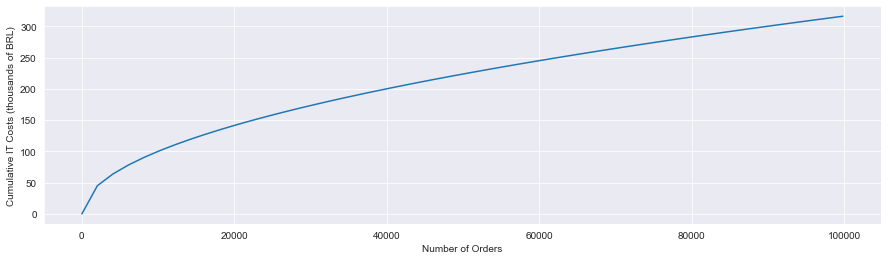

In [19]:
# Rough sketch of the IT cost curve with a generic y = x**(1/2) curve

plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 50)
y=x**0.5
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('Cumulative IT Costs (thousands of BRL)');


If we do a little math, we can solve for the proportionality constant *k* by evaluating the definite integral from 0 to the current number of orders *n*, and setting this equal to 500,000.

$\int_{0}^{n} k\sqrt{n}$ = 500,000    

where *n* is the number of orders and *k* is a proportionality constant

In [20]:
# total of n_orders
total_orders = sellers.n_orders.sum()
total_orders

99844

Evaluate the integral from 0 orders to the total cumulative number of orders 99,844. 

**$\int_{0}^{n} k\sqrt{n} \to \int_{0}^{99,844} k(\frac{2}{3}) n^\frac{3}{2} - k(\frac{2}{3}) (0)^\frac{3}{2} $**

We can then set this equal to 500,000 and solve for the proportionality constant *k*

**$ k(\frac{2}{3}) (99,844)^\frac{3}{2} = 500,000 $**

In [21]:
# Evaluating integral and solving for proportionatity constant k
k = 500000 / ((2/3)*(99844**1.5))
k

0.023772688842554592

We can see that the proportionality constant **k** $\approx$ **0.024**

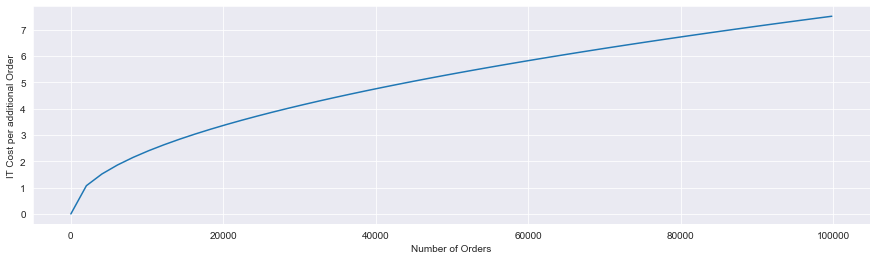

In [22]:


plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 50)
y=(k)*(x**0.5)
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost per additional Order');

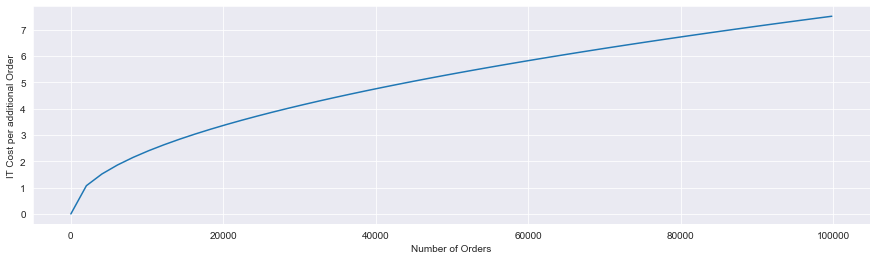

In [23]:
plt.figure(figsize=(15,4))
x=np.linspace(0,99844, 50)
y=(k)*(x**0.5)
sns.lineplot(x=x, y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Cost per additional Order');

Now that we have the proportionality constant *k*, we can calculate the additional IT cost associated with a particular order volume. 

Understanding this will help us gauge whether removing the poorest-performing sellers along with their order volume would adversely impact Olist's cost structure. 

Sellers with high order volume also have accompanying higher IT costs associated with them. If poor-performing sellers both pose a drag on profits from the effects of bad reviews, and additionally, with large order volume consume a larger of IT resources, then it becomes even clearer that removal of these sellers would improve profits and relieve the burden on the IT infrastructure.  

In [98]:
#Calculating IT costs per additional seller on the platform 

# The cumulative total of orders on the platform after adding this seller
sellers['cumulative_orders'] = sellers['n_orders'].cumsum()

# The cumulative total IT cost for Olist after adding this seller
sellers['cumulative_it_cost'] = k*(2/3)*(sellers['cumulative_orders']**1.5)

# The average cost of IT per order after adding this seller
sellers['it_unit_cost'] = sellers.cumulative_it_cost / sellers.cumulative_orders

# # The marginal IT cost for Olist after adding this seller
# sellers['it_marg_cost'] = k*sellers['cumulative_orders']**0.5

# # Difference between average and marginal IT cost
# sellers['diff_unit_marg_it'] = sellers.it_unit_cost - sellers.it_marg_cost
#sellers['diff_unit_marg_it'].abs().min()

sellers.head(50)

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion,cumulative_orders,cumulative_it_cost,it_unit_cost,it_marg_cost,diff_unit_marg_it
0,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.000000,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,0.097765,0.558659,...,17967.605,positive,17967.605,1.426629,0.033670,358,107.352358,0.299867,0.449800,-0.149933
1,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.000000,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,22.0,0.104167,0.627976,...,14603.187,positive,32570.792,2.586122,0.067340,694,289.751873,0.417510,0.626265,-0.208755
2,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.000000,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,0.088889,0.673504,...,14254.203,positive,46824.995,3.717906,0.101010,1279,724.924643,0.566790,0.850185,-0.283395
3,edb1ef5e36e0c8cd84eb3c9b003e486d,teresopolis,RJ,0.000000,11.709806,2017-09-30 09:49:22,2018-08-20 19:30:10,11.0,0.066265,0.692771,...,7288.455,positive,54113.450,4.296610,0.134680,1445,870.540173,0.602450,0.903675,-0.301225
4,ccc4bbb5f32a6ab2b7066a4130f114e3,curitiba,PR,0.000000,15.853247,2017-01-07 14:00:13,2018-08-21 21:05:16,20.0,0.085561,0.652406,...,6780.462,positive,60893.912,4.834979,0.168350,1632,1044.882074,0.640246,0.960370,-0.320123
5,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.000000,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,0.117083,0.623800,...,6761.119,positive,67655.031,5.371812,0.202020,2153,1583.263106,0.735375,1.103063,-0.367688
6,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,0.000000,15.005261,2017-03-07 13:04:43,2018-08-24 19:55:21,18.0,0.108657,0.593640,...,6487.263,positive,74142.294,5.886901,0.235690,3285,2983.940148,0.908353,1.362530,-0.454177
7,5dceca129747e92ff8ef7a997dc4f8ca,santa barbara d´oeste,SP,0.000000,11.273755,2017-01-27 14:31:27,2018-06-26 00:33:18,17.0,0.141538,0.581538,...,6175.553,positive,80317.847,6.377240,0.269360,3610,3437.540707,0.952227,1.428341,-0.476114
8,17f51e7198701186712e53a39c564617,sao paulo,SP,0.000000,22.761424,2017-02-04 13:05:50,2018-08-05 10:25:16,18.0,0.053571,0.660714,...,5641.900,positive,85959.747,6.825207,0.303030,3666,3517.837206,0.959585,1.439377,-0.479792
9,e882b2a25a10b9c057cc49695f222c19,teresopolis,RJ,0.000000,9.458803,2018-01-06 14:13:02,2018-08-18 16:10:04,8.0,0.016949,0.728814,...,5505.754,positive,91465.501,7.262364,0.336700,3723,3600.199782,0.967016,1.450524,-0.483508


In [25]:
sellers[sellers.impact == 'positive'].tail(1)

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,...,sales,revenue_per_seller,profit_per_seller,impact,cumulative_profits,percent_profits,seller_proportion,cumulative_orders,cumulative_it_cost,it_unit_cost
2693,19484c79cef6c062cb177aa4ef2fcc3c,valinhos,SP,5.179676,21.425822,2018-08-03 14:50:16,2018-08-03 14:50:16,1.0,1.0,0.0,...,201.9,100.19,0.19,positive,1572721.726,124.874167,90.707071,60027,233081.071184,3.882937


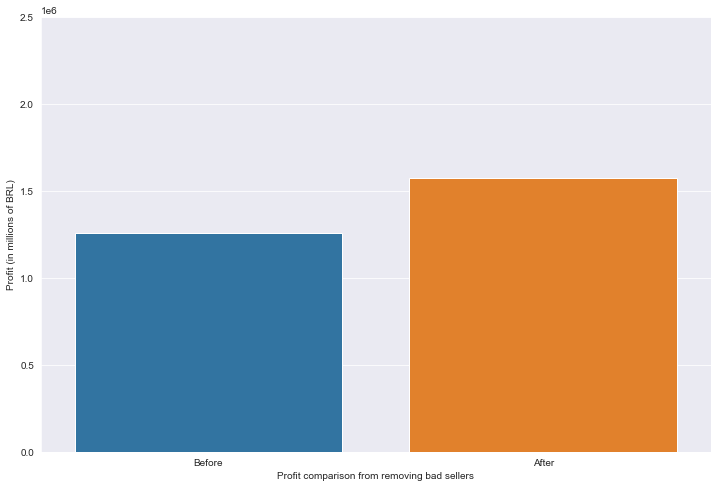

In [26]:
# Bar chart comparing diffence in average IT costs
plt.figure(figsize=(12,8))
x_values = ['Before', 'After']
y_values = [sellers.cumulative_profits.iloc[-1], sellers.cumulative_profits.iloc[-1] - neg_profits.iloc[-1]]
sns.barplot(data=sellers, x=x_values, y=y_values)
plt.ylabel('Profit (in millions of BRL)')
plt.ylim(0, 2500000)
plt.xlabel('Profit comparison from removing bad sellers');



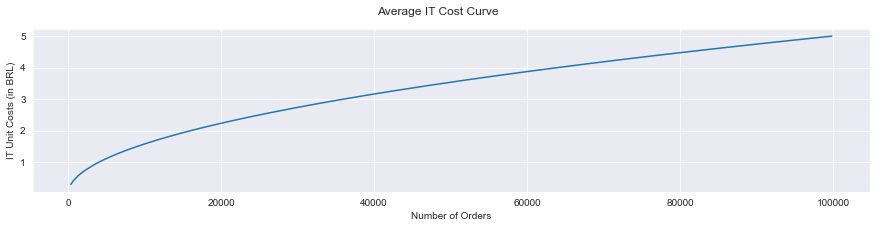

In [27]:
# Average IT Cost Curve

plt.figure(figsize=(15,3))
y= sellers.it_unit_cost
sns.lineplot(data=sellers, x='cumulative_orders', y=y)
plt.xlabel('Number of Orders')
plt.ylabel('IT Unit Costs (in BRL)')
plt.suptitle('Average IT Cost Curve');



From the **Average IT Cost Curve**, we can see that with increasing orders, the average IT cost burden for each additional order also increases though at a slow pace. 

Without removing the poor-performing sellers and their order volume, the average IT cost per order is 5.00 BRL. However, because this group of sellers has a large order volume comprising 40% of all orders, removing them from the platform would actually push Olist back on the Average IT Cost curve and reduce the average IT cost to 3.88 BRL. 


### Order Volume

Let's compare the order volume for these two groups of sellers.

In [28]:
#Calculate the number of orders from poor-performing sellers
bad_seller_volume = total_orders - sellers[sellers['impact']=='negative']['cumulative_orders'].iat[0]
bad_seller_volume

39816

In [29]:
#Calculate the number of orders from good sellers
good_seller_volume = total_orders - bad_seller_volume
good_seller_volume

60028

In [30]:
order_vol_df = sellers[['n_orders','impact']].groupby('impact').sum()
order_vol_df

,n_orders
impact,
negative,39817
positive,60027


In [31]:
order_vol_df.transpose()

impact,negative,positive
n_orders,39817,60027


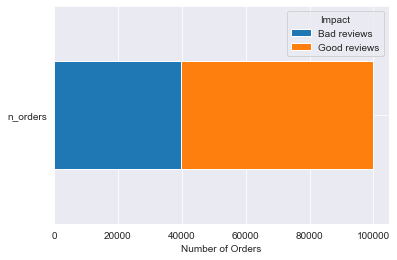

In [32]:
order_vol_df.transpose().plot.barh(stacked=True)
plt.legend(title='Impact', labels=['Bad reviews', 'Good reviews'])
plt.xlabel('Number of Orders');

In [33]:
# Average order volume for poor-performing sellers
sellers[sellers.impact == 'negative']['n_orders'].mean()

144.2644927536232

In [80]:
# Average order volume for good sellers
sellers[sellers.impact == 'positive']['n_orders'].mean()

22.28173719376392

In [86]:
avg_order_vol = sellers[['n_orders','impact']].groupby('impact').mean()

avg_order_vol.columns = ['Avg Num of Orders']
avg_order_vol
avg_order_vol.transpose()


impact,negative,positive
Avg Num of Orders,144.264493,22.281737


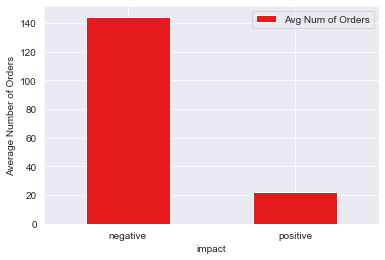

In [89]:
avg_order_vol.plot(kind='bar', cmap='Set1', ylabel='Average Number of Orders', rot=0  );

Poor-performing sellers make up 40% of total order volume and have an average order volume of roughly 7x more than other sellers. This underscores their heavy usage of the IT infrastructure and extra IT cost burden.

Our recommendation would be to consider removing them from the platform for:  
1) an immediate X% boost in earnings, and 
2) a reduction in a heavy IT cost burden 

Let's also re-plot our IT cost curve now that we know the proportionality constant.

$ y = k \sqrt{n}  \to  y = 0.024\sqrt{n} $

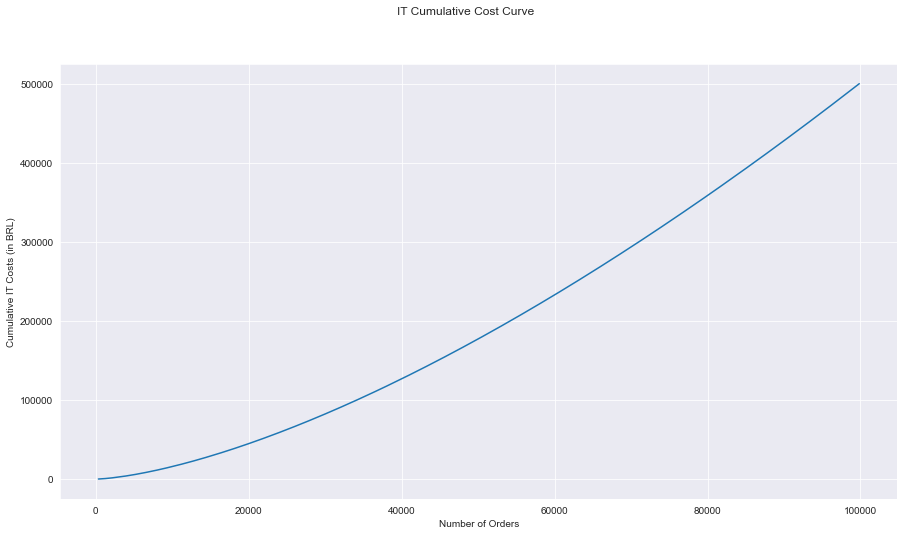

In [35]:

plt.figure(figsize=(15,8))
sns.lineplot(data=sellers, x='cumulative_orders', y='cumulative_it_cost')
plt.xlabel('Number of Orders')
plt.ylabel('Cumulative IT Costs (in BRL)')
plt.suptitle('IT Cumulative Cost Curve');


In [ ]:
# Total IT Cost with poor performers removed
it_cost_post_removal = 0.024*(2/3)*((60028)**1.5)
it_cost_post_removal

In [ ]:
# Average IT cost per order w/ poor performers removed
it_cost_post_removal / good_seller_volume

Let's now compare the average IT cost on the platform before and after removing poor-performing sellers



In [ ]:
sellers[sellers['impact']=='positive'].tail()

In [ ]:
# Average IT cost per order after removing poor performers 
sellers[sellers['impact']=='positive']['cumulative_it_cost'] / sellers[sellers['impact']=='positive']['cumulative_orders'].iat[-1]

In [ ]:
# Average IT cost per order before removing poor performers
sellers.it_cost.sum() / total_orders

In [ ]:
#Let's plot the average IT cost curve
x = np.linspace(1,99844, 1)
y = sellers. / x


plt.figure(figsize=(15,4))
sns.lineplot(x=x, y=y)
plt.xlabel('Number of orders')
plt.ylabel('Average IT cost per order')
plt.set_ylim(0, );


In [ ]:
#Profits per number of sellers removed [DO AFTER FACTOR IN IT COSTS]
sellers['olist_profits'] = sellers['profit_per_seller'] - sellers['it_cost']
sellers.loc[2680:2690]

In [ ]:
sellers['olist_profits'][10:700].plot(figsize=(15,8));

In [ ]:
sellers['olist_profits'].plot(figsize=(15,8));

In [ ]:
sellers.loc[50:100, :]

In [ ]:
sellers['n_orders'].sort_values()

# Recommendation: 

## Remove poorest performing sellers on Olist platform for immediate profit increase

## Profit Analysis

- 280 poorest-performing sellers have negative impact on profits
- Top 100 highest performing sellers comprise bulk of profits

In [ ]:
# If sellers ordered by level of contribution to Olist profits

sellers['olist_profits'].plot(figsize=(15,7))
plt.xlabel('Number of Sellers')
plt.ylabel('Profit (BRL)')
plt.show()


## Profit Analysis

- Immediate profit increase of 320K BRL

In [ ]:
x_values = ['Before', 'After']
y_values = [1.25, 1.57]
plt.bar(x_values, y_values)
plt.ylabel('Profit (Millions of BRL)')
plt.ylim(0, 2)
plt.show()


## IT Cost Concerns 

- Increase in marginal costs due to drop in sellers negligible
- Some poorest-performing sellers contribute to larger share of IT cost burden


In [ ]:
sellers['it_cost'].plot(figsize=(15,7))
plt.xlabel('Number of Sellers')
plt.ylabel('IT Cost per Seller (BRL)')
plt.show()


In [ ]:
sellers['it_cost'][10:700].plot()

In [ ]:
ax1 = sellers['it_cost'].plot()
ax1.set(xlim=[0,3000], ylim=[-1000,2000])

ax2 = sellers['olist_profits'].plot()
ax2.set(xlim=[0,3000], ylim=[-1000,2000])
plt.xlabel['']




## Areas to Explore Further

- Evaluate whether can improve average seller performance
- Explore reviews for cause of dissatisfaction